# separte workflow for coregistration of anatomical image to mni template

In [4]:
# import modules
from os.path import join as opj
import os
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import FreeSurferSource, SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.ants import Registration
from nipype.interfaces.fsl import Info, BET

In [13]:
experiment_dir = '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/' # location of experiment folder
subject_list = ['sub-00'] # create the subject_list variable
# run_list = ['1', '2', '3', '4', '5', '6', '7', '8']

output_dir = 'derivatives/antsreg/output_dir/' # name of output folder
working_dir = 'derivatives/antsreg/working_dir/' # name of working directory

number_of_slices = 25   # number of slices in volume
TR = 1.5    # time of repetition of volume

fwhm = [4,6]

# location of template file for coregistration to mni template (full path needed, error otherwise)
template = '/media/lmn/86A406A0A406933B/mni_icbm152_nlin_asym_09c_3mm/mni_icbm152_t1_tal_nlin_asym_09c.nii'

In [18]:
# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'anat': '/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/sub-01/mri/brain.mgz'} # anatomical images
        
selectfiles = Node(SelectFiles(templates,
                                base_directory=experiment_dir),
                   name="selectfiles")

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [19]:
# BET - Skullstrip mask Image
bet_temp = Node(BET(frac=0.5,
                    robust=True,
                    in_file=template,
                    output_type='NIFTI_GZ'),
                name="bet_temp")

# antsRegistration - coregister t1 on mni template
registrationtemp = Node(Registration(args='--float',
                            collapse_output_transforms=True,
                            initial_moving_transform_com=True,   # no additional connection in workflow needed
                            num_threads=4,
                            output_inverse_warped_image=True,
                            output_warped_image=True,
                            sigma_units=['vox']*3,
                            transforms=['Rigid', 'Affine', 'SyN'],
                            terminal_output='file',
                            winsorize_lower_quantile=0.005,
                            winsorize_upper_quantile=0.995,
                            convergence_threshold=[1e-06],
                            convergence_window_size=[10],
                            metric=['MI', 'MI', 'CC'],
                            metric_weight=[1.0]*3,
                            number_of_iterations=[[1000, 500, 250, 100],
                                                  [1000, 500, 250, 100],
                                                  [100, 70, 50, 20]],
                            radius_or_number_of_bins=[32, 32, 4],
                            sampling_percentage=[0.25, 0.25, 1],
                            sampling_strategy=['Regular',
                                               'Regular',
                                               'None'],
                            shrink_factors=[[8, 4, 2, 1]]*3,
                            smoothing_sigmas=[[3, 2, 1, 0]]*3,
                            transform_parameters=[(0.1,),
                                                  (0.1,),
                                                  (0.1, 3.0, 0.0)],
                            use_histogram_matching=True,
                            write_composite_transform=True),
               name='registrationtemp')

In [23]:
# visualize
# Create preproc output graph
reg_HOAF.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph


180726-15:16:33,698 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/reg_HOAF/graph.png (graph2use=colored, simple_form=True).


'/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/reg_HOAF/graph.png'

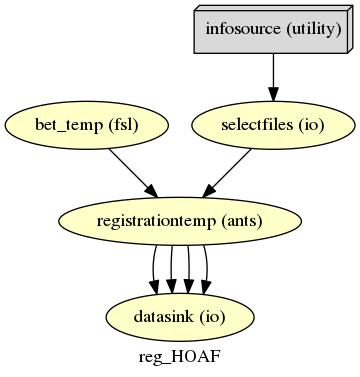

In [25]:
from IPython.display import Image
Image(filename='/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/reg_HOAF/graph.png', width=750)

<bound method Node.get_output of <nipype.pipeline.engine.nodes.Node object at 0x7f8fea1af5f8>>


In [20]:
# Create a preprocessing workflow
reg_HOAF = Workflow(name='reg_HOAF')
reg_HOAF.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow - aparc / ribbon mask 
reg_HOAF.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                  (selectfiles, registrationtemp, [('anat', 'moving_image')]),
                  (bet_temp, registrationtemp, [('out_file', 'fixed_image')]),
                  (registrationtemp, datasink, [('warped_image', 'registrationtemp.@warped_image'),
                                                ('inverse_warped_image', 'registrationtemp.@inverse_warped_image'),
                                                ('inverse_composite_transform', 'registrationtemp.@inverse_composite_transform'),
                                                ('composite_transform', 'registrationtemp.@composite_transform')]),
                      ])

In [21]:
#### run the workflow using multiple cores ####
reg_HOAF.run('MultiProc', plugin_args={'n_procs':4})

180726-13:49:41,862 nipype.workflow INFO:
	 Workflow reg_HOAF settings: ['check', 'execution', 'logging', 'monitoring']
180726-13:49:41,874 nipype.workflow INFO:
	 Running in parallel.
180726-13:49:41,877 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 4/4.
180726-13:49:41,937 nipype.workflow INFO:
	 [Job 1] Cached (reg_HOAF.bet_temp).
180726-13:49:41,937 nipype.workflow INFO:
	 [Node] Setting-up "reg_HOAF.selectfiles" in "/media/lmn/86A406A0A406933B/HOAF/HOAF_BIDS/derivatives/preprocessing_sub01/working_dir/reg_HOAF/_subject_id_sub-00/selectfiles".
180726-13:49:41,944 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180726-13:49:41,955 nipype.workflow INFO:
	 [Node] Finished "reg_HOAF.selectfiles".
180726-13:49:43,879 nipype.workflow INFO:
	 [Job 0] Completed (reg_HOAF.selectfiles).
180726-13:49:43,881 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Fr